[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Borgers-Examples-in-BMTK/blob/main/31-ING_Entrainment/31_ING.ipynb)

# Chapter 31- ING Entrainment of E - Cells
#### by Matthew Stroud and Gregory Glickert
This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

In this tutorial,we display an Interneuronal Network Gamma (ING) network entrain excitatory neurons (E-cells). Gamma rhythms are 30-80 Hz, thus the firing of the E-cells must be within this range. We model 400 E-cells with an RTM model and the ING cells with a WB model.

requirements:

 bmtk

 NEURON 7.4+

### Create nodes
The ING network, E-cells, and external input nodes are defined

In [1]:
import os
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython()) 
if RunningInCOLAB:  
  %pip install neuron==8.2.4 &> /dev/null
  %pip install bmtk &> /dev/null
  %pip install h5py==2.9.0 &> /dev/null

  root = 'Borgers-Examples-in-BMTK' # name of github repo
  folder = '31-ING_Entrainment'
  pathlist = normpath(os.getcwd()).split(sep)
  if pathlist[-1] != folder:
    rootidx = pathlist.index(root) if root in pathlist else -1
    if rootidx>0:
      os.chdir(join(sep,*pathlist[:rootidx]))
    !git clone https://github.com/Cyneuro/Borgers-Examples-in-BMTK
    os.chdir(join(root,folder))
    
print(os.system('nrnivmodl components/mechanisms')) # compile modfiles. Return 0 for success, 1 for failure.

/home/gjgpb9/Borgers-Examples-in-BMTK/31-ING_Entrainment
Mod files: "components/mechanisms/components/mechanisms/gap.mod" "components/mechanisms/components/mechanisms/k_rtm.mod" "components/mechanisms/components/mechanisms/k_wb.mod" "components/mechanisms/components/mechanisms/leak.mod" "components/mechanisms/components/mechanisms/na_rtm.mod" "components/mechanisms/components/mechanisms/na_wb.mod" "components/mechanisms/components/mechanisms/vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special
0


/home/gjgpb9/miniconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


In [2]:
import numpy as np
import logging
import math

from bmtk.builder.networks import NetworkBuilder

# E - Cells
n_E = 400

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

# ING network
n_I = 100

net.add_nodes(N=n_I, pop_name='ING',     # N = number of ING cells
        model_type='biophysical',
        model_template='hoc:WBInhCell', 
        morphology='blank.swc')

### Connection rules 

We add connections based on a probability defined below. To prevent autapses, if the node_id is equal between source and targe cell, no connection is made.

In [3]:
import random

def syn_connector(source,target,p):
    if source['node_id'] == target['node_id']:
        return 0
    return 1 if random.random() < p else 0

### Creating ING Edges

Probabilities and conductances are taken from chapter 31 of Borgers' book. Inhibitory connections between ING cells are added; Inhibitory connections from ING cells to E - cells are added; gap juctions between ING cells are added.

In [4]:
g_ee = 0
g_ei = 0
g_ie = 0.5  #0.5
g_ii = 0.5  #0.5
g_gap = 0.1

p_gap = 0.05
p_ee = 1
p_ei = 0.5
p_ie = 0.5  # 0.5
p_ii = 0.5   # 0.5



#E-E connections dont exist (g_ee = 0)
         
#E-I connections dont exist (g_ei = 0)

#I-I connections
net.add_edges(source={'pop_name':'ING'}, target={'pop_name':'ING'},
                    connection_rule=syn_connector, 
                    connection_params={'p':p_ii},
                    delay=0,
                    syn_weight = g_ii/n_I,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToInh.json',
                    model_template='Exp2Syn')
                    
#I-E connections
net.add_edges(source={'pop_name':'ING'}, target={'pop_name':'Exc'},
                    connection_rule=syn_connector,
                    connection_params={'p':p_ie},
                    delay=0,
                    syn_weight = g_ie/n_I,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToExc.json',
                    model_template='Exp2Syn')

#gap junctions
net.add_edges(source={'pop_name':'ING'}, target={'pop_name':'ING'}, 
                      syn_weight=g_gap,
                      weight_function=None,
                      target_sections=['soma'],
                      model_template='Gap',
                      delay=0,
                      distance_range=[0.0, 0.1],
                      is_gap_junction=True,
                      connection_rule=syn_connector, 
                      connection_params={'p':p_gap})

In [5]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

In [6]:
from bmtk.builder.networks import NetworkBuilder

extnet = NetworkBuilder('extnet')

extnet.add_nodes(N=n_E+n_I, model_type='virtual', pop_name='bgnoisevirtExt', pop_group='bgnoisevirtExt')

def target_ind_equals_source_ind(source, targets, offset=0, min_syn=1,max_syn=1):
    # Creates a 1 to 1 mapping between source and destination nodes
    total_targets = len(targets)
    syns = np.zeros(total_targets)
    target_index = source['node_id']
    syns[target_index-offset] = 1
    return syns
        

g_bar_stoch = 0.03
conn = extnet.add_edges(target=net.nodes(pop_name='Exc'),
            source={'pop_name':'bgnoisevirtExt'},
            iterator='one_to_all',
            connection_rule=target_ind_equals_source_ind,
            connection_params={'offset':n_I},
            dynamics_params='PING_ExcToExc.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            target_sections=['soma'],
            delay=0,
            syn_weight=g_bar_stoch
            )

# i think the issue with this network is that it needs an ING Input something like this

# conn = extnet.add_edges(target=net.nodes(pop_name='ING'),
#             source={'pop_name':'bgnoisevirtExt'},
#             iterator='one_to_all',
#             connection_rule=target_ind_equals_source_ind,
#             connection_params={'offset':n_E},
#             dynamics_params='PING_ExcToExc.json',
#             model_template='exp2syn',
#             distance_range=[0.0,999.9],
#             target_sections=['soma'],
#             delay=0,
#             syn_weight=g_bar_stoch
#             )

extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

### setting up input

In [7]:
def generate_ext_poisson_input(n_E,freq=60,offset=0,population='extnet',times=(0.0, 1.0),filename='input/ext_inp_poisson.h5'):
    '''
    Generate poisson input for ext cells
    '''
    import os
    from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
    
    try:
        os.remove(filename)
    except OSError:
        pass
    
    psg = PoissonSpikeGenerator(population=population)
    psg.add(node_ids=range(offset,offset+n_E),  # Select nodes
            firing_rate=freq,     # 'freq' Hz, we can also pass in a nonhomoegenous function/array
            times=times)    # Firing starts at 0 s up to 1 s by default
    psg.to_sonata(filename)
    logging.info(filename + " written")


#n_E defined above
stoch_freq = 60

generate_ext_poisson_input(n_E,freq=stoch_freq,filename='input/ext_inp_poisson.h5',population='bgnoisevirtExt')

### Set up Simulation Environment

In [8]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=500.0, dt=0.1,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                'input/ext_inp_poisson.h5')],

                  current_clamp={            # Creates a step current from 500.ms to 1500.0 ms
                    'amp': 0.400,
                    'delay': 0,
                    'duration': 30.0
                  },
                 v_init= -65,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file ='config.json',
                 overwrite_config=True
                )

### Run the Simulation

In [9]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

numprocs=1
2025-01-24 12:18:51,907 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


NEURON mechanisms not found in /home/gjgpb9/Borgers-Examples-in-BMTK/31-ING_Entrainment/components/mechanisms.
2025-01-24 12:18:51,977 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2025-01-24 12:18:52,587 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2025-01-24 12:18:58,449 [INFO] Building virtual cell stimulations for extnet_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for extnet_spikes


2025-01-24 12:18:58,915 [INFO] Running simulation for 500.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 500.000 ms with the time step 0.100 ms


2025-01-24 12:18:58,916 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2025-01-24 12:18:58,917 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2025-01-24 12:19:31,779 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2025-01-24 12:19:31,832 [INFO] Simulation completed in 32.92 seconds 


INFO:NEURONIOUtils:Simulation completed in 32.92 seconds 


### Analyze Results

We did not add initial voltage values to the ING network nor the E - cells. Because of a synchronous initialization, only the ING cell entrainment of the E-cells can be observed. The E - cells are already synchronous.

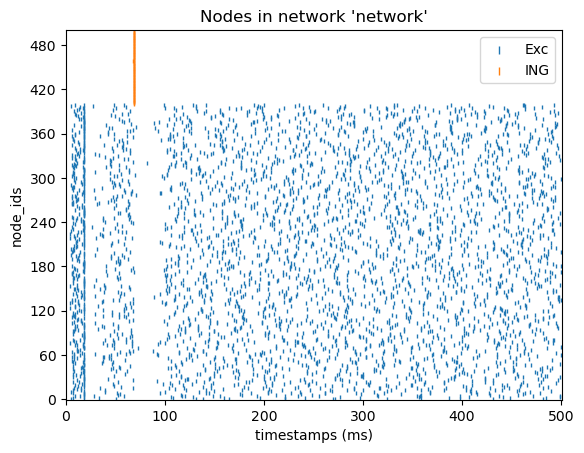

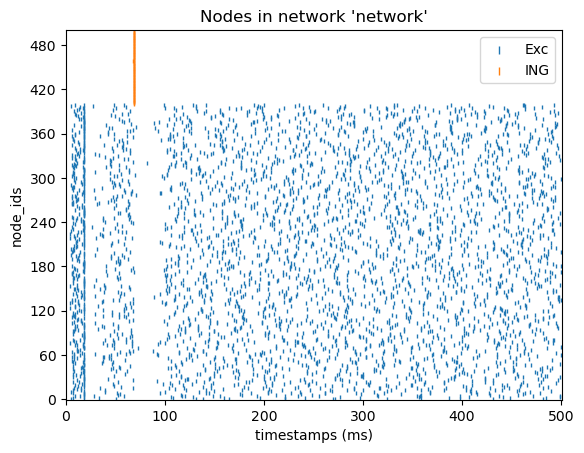

In [10]:
from bmtk.analyzer.spike_trains import plot_raster,plot_rates_boxplot

plot_raster(config_file='config.json', with_histogram=False, population='network', group_by='pop_name')

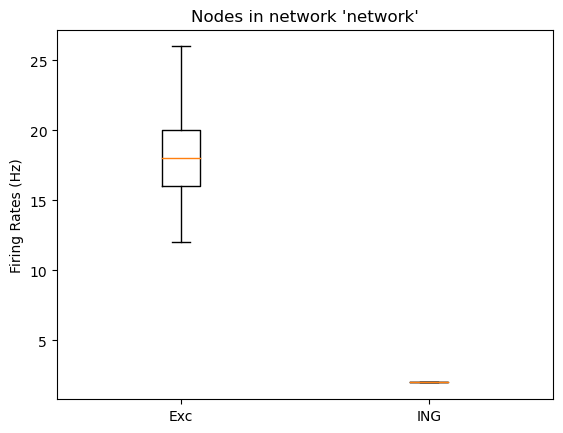

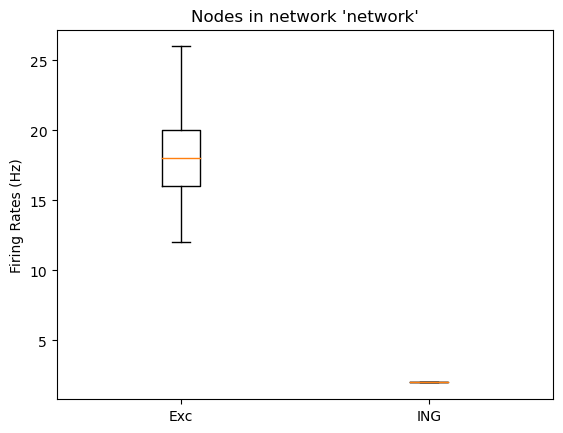

In [11]:
plot_rates_boxplot(config_file='config.json', group_by='pop_name')

The ING network successfully entrained the E-cells (Exc) at ~30 Hz which is in Gamma wave range